**Please set up your credentials JSON as GCP_CREDENTIALS secrets**

In [10]:
import os
from google.colab import userdata

os.environ["DESTINATION__CREDENTIALS"] = userdata.get("GCP_CREDENTIALS")
os.environ["BUCKET_URL"] = "gs://kestra-demo-oskedev1"

In [11]:
# Install for production
%%capture
!pip install dlt[bigquery, gs]

In [12]:
# Install for testing
%%capture
!pip install dlt[duckdb]

In [13]:
import dlt
import requests
import pandas as pd
from dlt.destinations import filesystem
from io import BytesIO

Ingesting parquet files to GCS.

In [14]:
# Define a dlt source to download and process Parquet files as resources
@dlt.source(name="rides")
def download_parquet():
    prefix = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata"
    for month in range(1, 7):
        file_name = f"yellow_tripdata_2024-0{month}.parquet"
        url = f"{prefix}_2024-0{month}.parquet"
        response = requests.get(url)

        df = pd.read_parquet(BytesIO(response.content))

        # Return the dataframe as a dlt resource for ingestion
        yield dlt.resource(df, name=file_name)


# Initialize the pipeline
pipeline = dlt.pipeline(
    pipeline_name="rides_pipeline",
    destination=filesystem(layout="{schema_name}/{table_name}.{ext}"),
    dataset_name="rides_dataset",
)

# Run the pipeline to load Parquet data into DuckDB
load_info = pipeline.run(download_parquet(), loader_file_format="parquet")

# Print the results
print(load_info)


Pipeline rides_pipeline load step completed in 19.55 seconds
1 load package(s) were loaded to destination filesystem and into dataset rides_dataset
The filesystem destination used gs://kestra-demo-oskedev1 location to store data
Load package 1770692386.3052578 is LOADED and contains no failed jobs


Ingesting data to Database

In [16]:
# Define a dlt resource to download and process Parquet files as single table
@dlt.resource(name="rides", write_disposition="replace")
def download_parquet():
    prefix = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata'

    for month in range(1, 7):
        url = f"{prefix}_2024-0{month}.parquet"
        response = requests.get(url)

        df = pd.read_parquet(BytesIO(response.content))

        yield df


# Initialize the pipeline
pipeline = dlt.pipeline(
    pipeline_name="rides_pipeline",
    destination="duckdb",  # Use DuckDB for testing
    # destination="bigquery",  # Use BigQuery for production
    dataset_name="rides_dataset",
)

# Temporarily store the original value of DESTINATION__CREDENTIALS
# and unset it to prevent interference with DuckDB
import os
original_credentials = os.environ.get("DESTINATION__CREDENTIALS")
if original_credentials:
    del os.environ["DESTINATION__CREDENTIALS"]

try:
    # Run the pipeline to load Parquet data into DuckDB
    info = pipeline.run(download_parquet)

    # Print the results
    print(info)
finally:
    # Restore DESTINATION__CREDENTIALS if it was originally set
    if original_credentials:
        os.environ["DESTINATION__CREDENTIALS"] = original_credentials


Pipeline rides_pipeline load step completed in 25.97 seconds
1 load package(s) were loaded to destination duckdb and into dataset rides_dataset
The duckdb destination used duckdb:////content/rides_pipeline.duckdb location to store data
Load package 1770692872.7353332 is LOADED and contains no failed jobs


In [24]:
# Define a dlt resource to download and process Parquet files as single table
@dlt.resource(name="rides", write_disposition="replace")
def download_parquet():
    prefix = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata'

    for month in range(1, 7):
        url = f"{prefix}_2024-0{month}.parquet"
        response = requests.get(url)

        df = pd.read_parquet(BytesIO(response.content))

        yield df


# Initialize the pipeline
pipeline = dlt.pipeline(
    pipeline_name="rides_pipeline",
    #destination="duckdb",  # Use DuckDB for testing
    destination="bigquery",  # Use BigQuery for production
    dataset_name="rides_dataset",
)

# Run the pipeline to load Parquet data into DuckDB
info = pipeline.run(download_parquet)

# Print the results
print(info)

2026-02-10 04:20:06,367|[WARNING]|524|132287704600576|dlt|pipeline.py|_state_to_props:1731|The destination dlt.destinations.duckdb:None in state differs from destination dlt.destinations.bigquery:bigquery in pipeline and will be ignored


Pipeline rides_pipeline load step completed in 43.38 seconds
1 load package(s) were loaded to destination bigquery and into dataset rides_dataset
The bigquery destination used dev-zoom-comp-kera@keras-demo-486202.iam.gserviceaccount.com@keras-demo-486202 location to store data
Load package 1770697207.9421518 is LOADED and contains no failed jobs


In [17]:
import duckdb

conn = duckdb.connect(f"{pipeline.pipeline_name}.duckdb")

# Set search path to the dataset
conn.sql(f"SET search_path = '{pipeline.dataset_name}'")

# Describe the dataset to see loaded tables
res = conn.sql("DESCRIBE").df()
print(res)

         database         schema                 name  \
0  rides_pipeline  rides_dataset           _dlt_loads   
1  rides_pipeline  rides_dataset  _dlt_pipeline_state   
2  rides_pipeline  rides_dataset         _dlt_version   
3  rides_pipeline  rides_dataset                rides   

                                        column_names  \
0  [load_id, schema_name, status, inserted_at, sc...   
1  [version, engine_version, pipeline_name, state...   
2  [version, engine_version, inserted_at, schema_...   
3  [vendor_id, tpep_pickup_datetime, tpep_dropoff...   

                                        column_types  temporary  
0  [VARCHAR, VARCHAR, BIGINT, TIMESTAMP WITH TIME...      False  
1  [BIGINT, BIGINT, VARCHAR, VARCHAR, TIMESTAMP W...      False  
2  [BIGINT, BIGINT, TIMESTAMP WITH TIME ZONE, VAR...      False  
3  [INTEGER, TIMESTAMP WITH TIME ZONE, TIMESTAMP ...      False  


In [23]:
# provide a resource name to query a table of that name

# Temporarily store the original value of DESTINATION__CREDENTIALS
# and unset it to prevent interference with DuckDB
import os
original_credentials_query = os.environ.get("DESTINATION__CREDENTIALS")
if original_credentials_query:
    del os.environ["DESTINATION__CREDENTIALS"]

try:
    with pipeline.sql_client() as client:
        with client.execute_query(f"SELECT * FROM rides limit 100") as cursor:
            data = cursor.df()
    print(data)
finally:
    # Restore DESTINATION__CREDENTIALS if it was originally set
    if original_credentials_query:
        os.environ["DESTINATION__CREDENTIALS"] = original_credentials_query


    vendor_id      tpep_pickup_datetime     tpep_dropoff_datetime  \
0           2 2024-01-01 00:57:55+00:00 2024-01-01 01:17:43+00:00   
1           1 2024-01-01 00:03:00+00:00 2024-01-01 00:09:36+00:00   
2           1 2024-01-01 00:17:06+00:00 2024-01-01 00:35:01+00:00   
3           1 2024-01-01 00:36:38+00:00 2024-01-01 00:44:56+00:00   
4           1 2024-01-01 00:46:51+00:00 2024-01-01 00:52:57+00:00   
..        ...                       ...                       ...   
95          2 2024-01-01 00:54:16+00:00 2024-01-01 01:27:40+00:00   
96          2 2024-01-01 00:13:58+00:00 2024-01-01 00:33:39+00:00   
97          2 2024-01-01 00:35:53+00:00 2024-01-01 00:47:59+00:00   
98          2 2024-01-01 00:50:28+00:00 2024-01-01 01:38:39+00:00   
99          2 2024-01-01 00:18:24+00:00 2024-01-01 00:30:39+00:00   

    passenger_count  trip_distance  ratecode_id store_and_fwd_flag  \
0               1.0           1.72          1.0                  N   
1               1.0           1



---



# **Homework 3:**

## What is count of records for the 2024 Yellow Taxi Data?

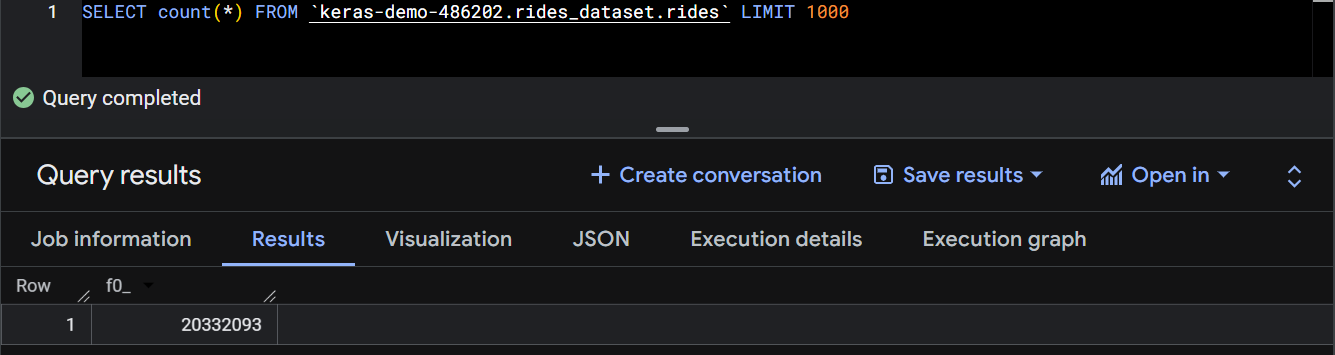

### ANS : 20,332,093



---



## Question 2. Data read estimation
### Write a query to count the distinct number of PULocationIDs for the entire dataset on both the tables.

### What is the estimated amount of data that will be read when this query is executed on the External Table and the Table?

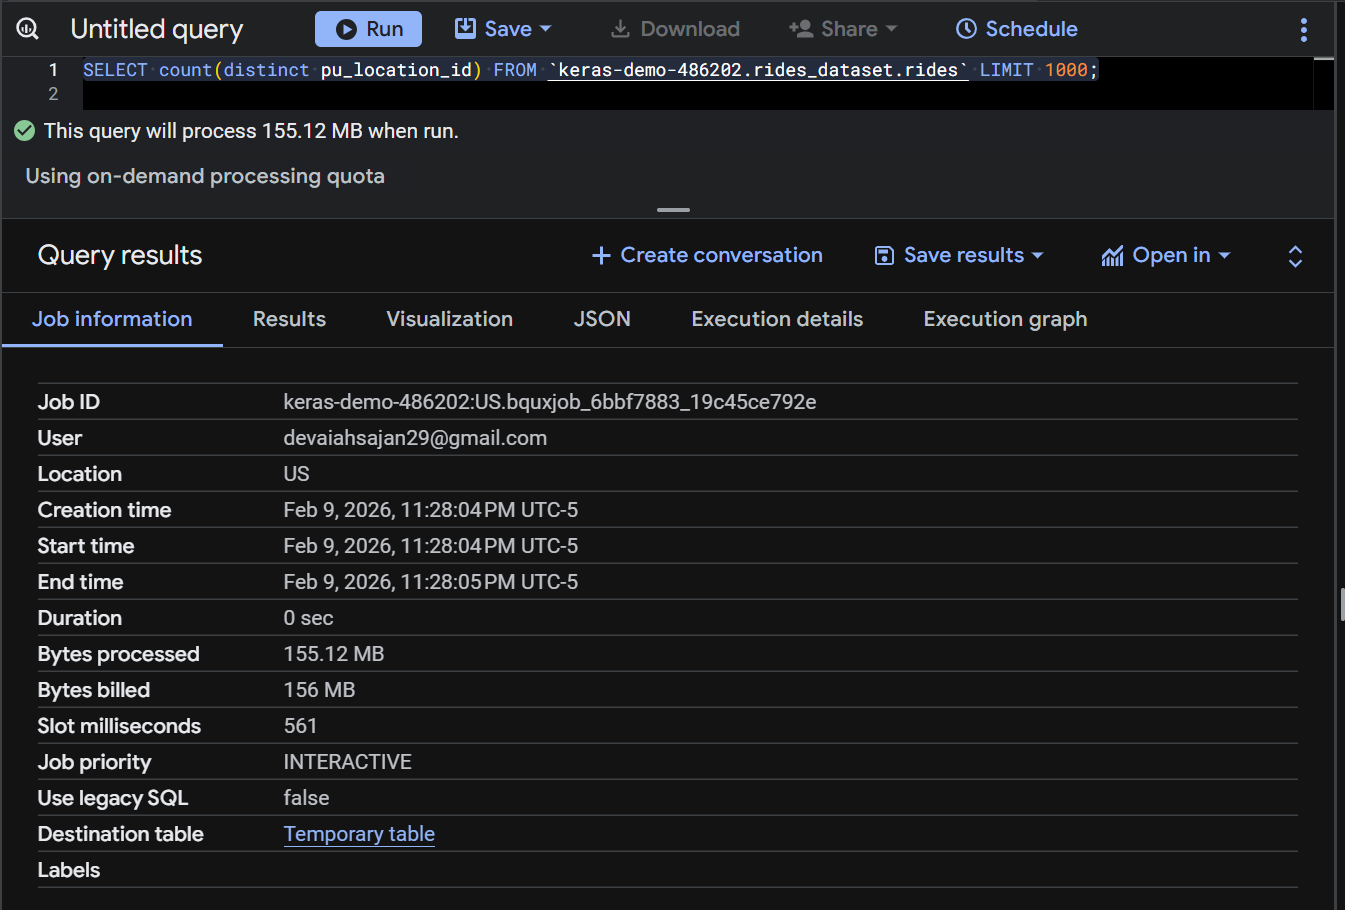

### Ans: 0 MB for the External Table and 155.12 MB for the Materialized Table



---



# Question 3. Understanding columnar storage
Write a query to retrieve the PULocationID from the table in BigQuery. Now write a query to retrieve the PULocationID and DOLocationID on the same table.

Why are the estimated number of Bytes different?

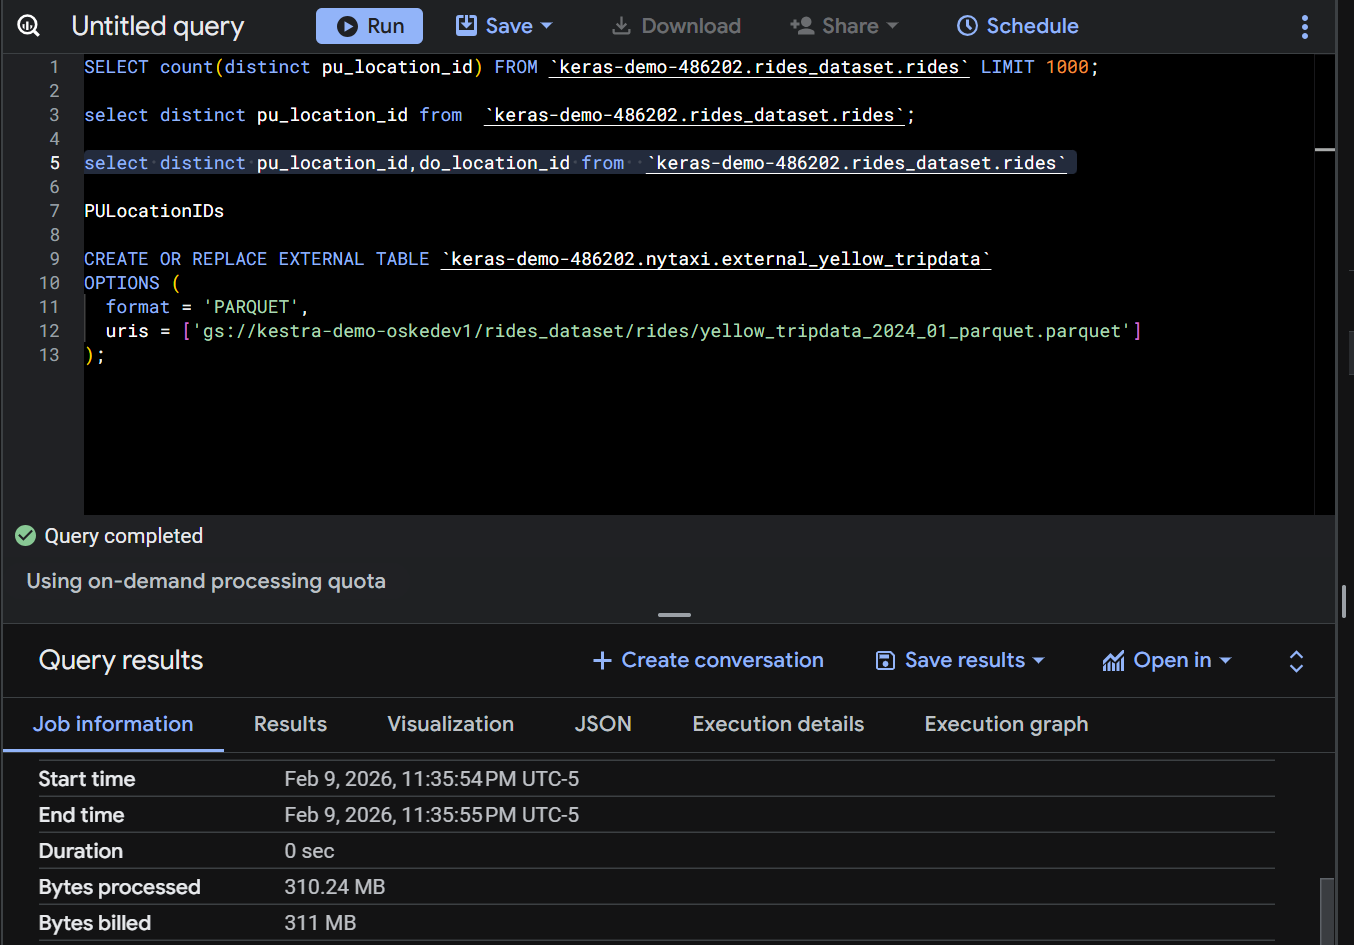

### Ans : BigQuery is a columnar database, and it only scans the specific columns requested in the query. Querying two columns (PULocationID, DOLocationID) requires reading more data than querying one column (PULocationID), leading to a higher estimated number of bytes processed.



---



## Question 4. Counting zero fare trips
How many records have a fare_amount of 0?

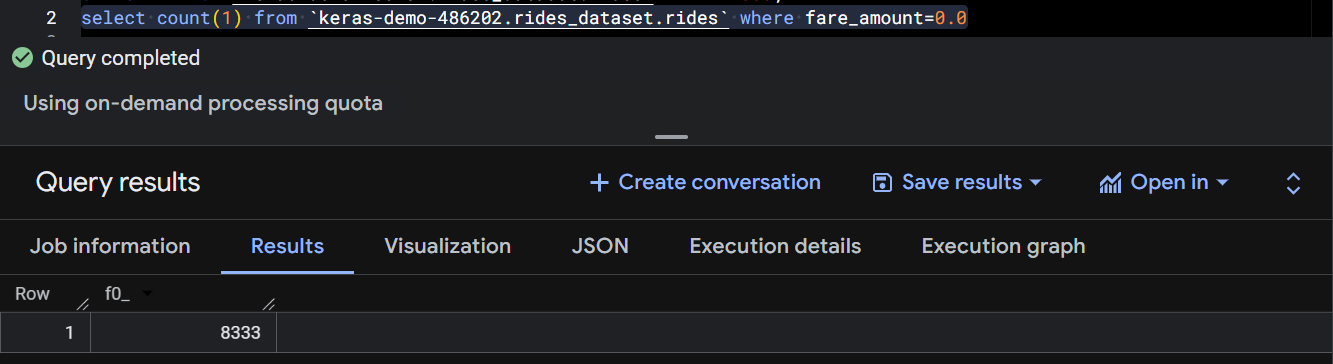

### Ans : 8333



---



# Question 5. Partitioning and clustering
What is the best strategy to make an optimized table in Big Query if your query will always filter based on tpep_dropoff_datetime and order the results by VendorID (Create a new table with this strategy)

## SQL
```
 CREATE OR REPLACE TABLE `keras-demo-486202.rides_dataset.partioned_rides`
PARTITION BY DATE(tpep_dropoff_datetime )
CLUSTER BY Vendor_ID AS (
  SELECT * FROM `keras-demo-486202.rides_dataset.rides`
```



Ans : Partition by tpep_dropoff_datetime and Cluster on VendorID



---



# Question 6. Partition benefits
Write a query to retrieve the distinct VendorIDs between tpep_dropoff_datetime 2024-03-01 and 2024-03-15 (inclusive)

Use the materialized table you created earlier in your from clause and note the estimated bytes. Now change the table in the from clause to the partitioned table you created for question 5 and note the estimated bytes processed. What are these values?

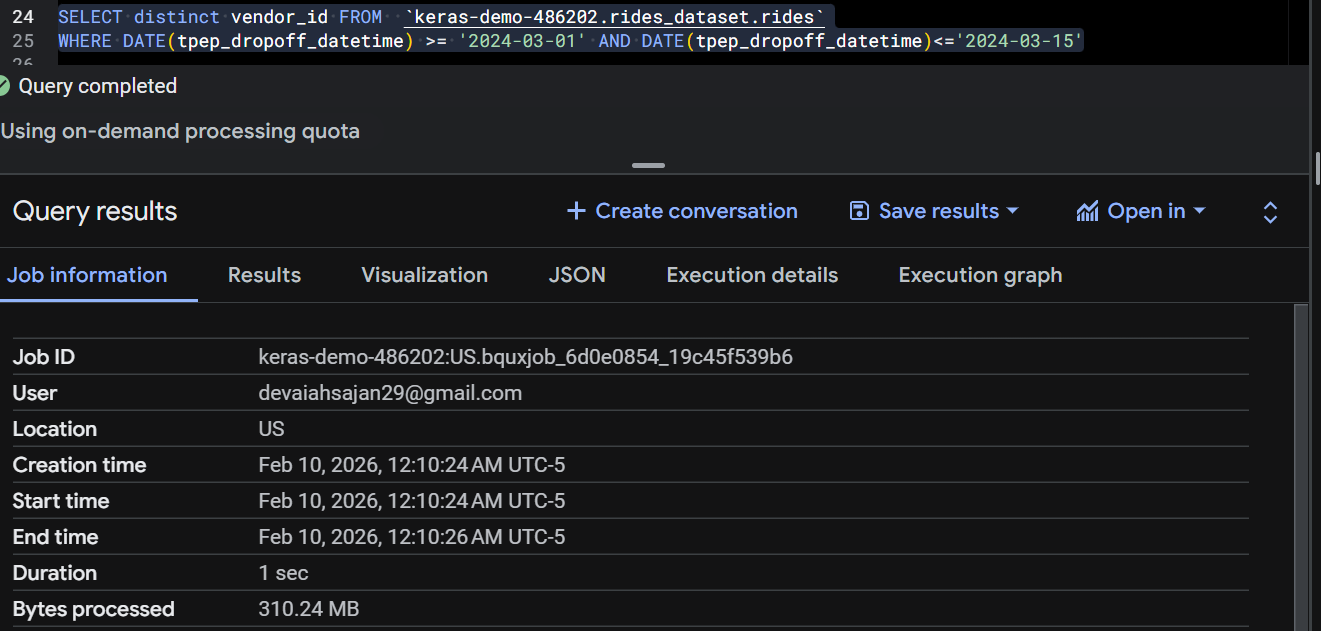

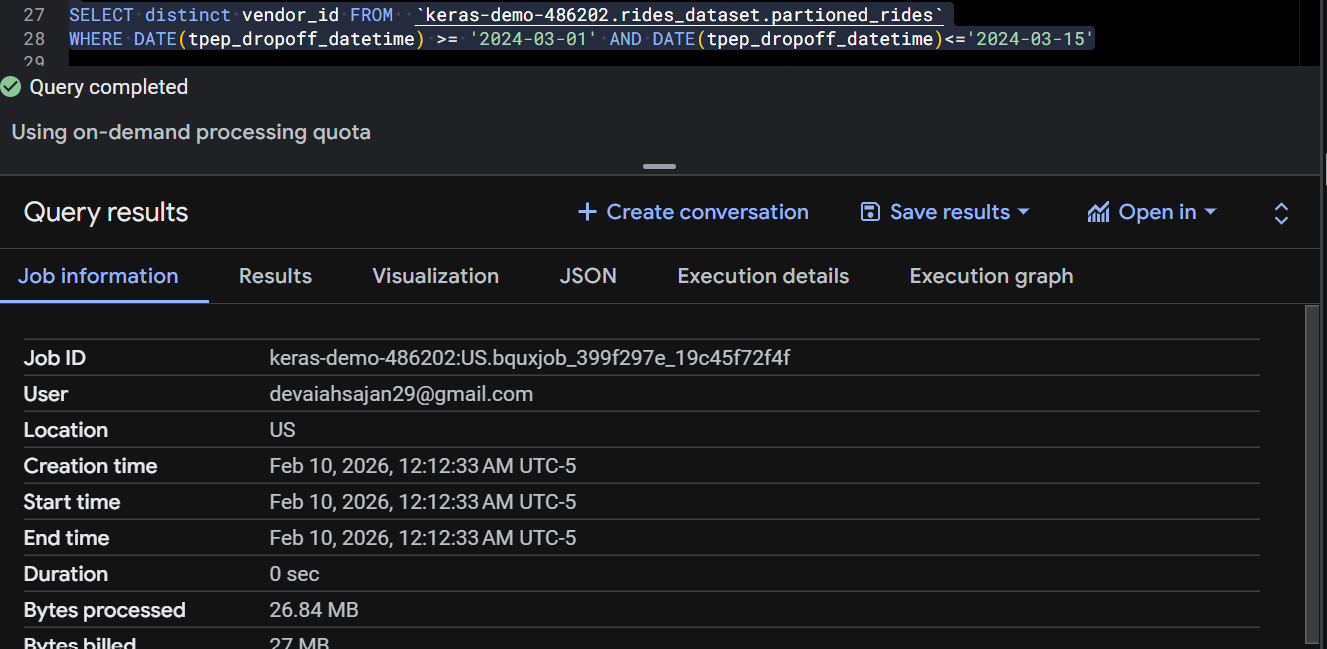

Ans: 310.24 MB for non-partitioned table and 26.84 MB for the partitioned table



---



# Question 7. External table storage
Where is the data stored in the External Table you created?

Ans: GCP Bucket



---



# Question 8. Clustering best practices
It is best practice in Big Query to always cluster your data:

Ans : False , Only for repeated sorting query



---



# Question 9. Understanding table scans

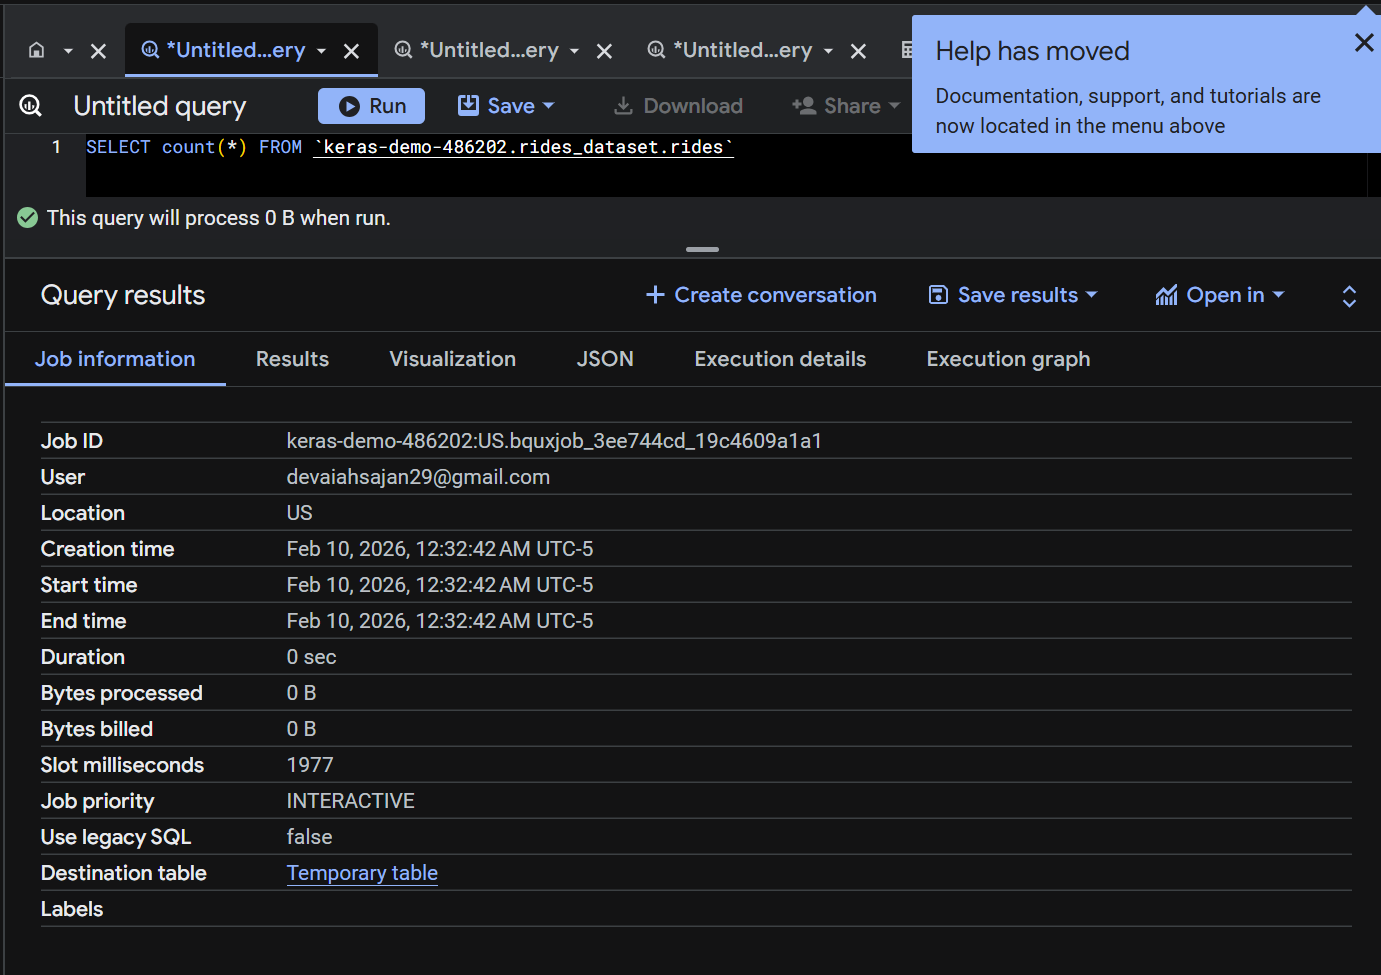

Ans: temporary tables from cache